In [1]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# Importing required packages.
import pandas as pd
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint

In [4]:
# Reading all dataframes needed for modeling.
X_train = pd.read_pickle("../preprocessing/X_train.pkl")
X_val = pd.read_pickle("../preprocessing/X_val.pkl")
X_test = pd.read_pickle("../preprocessing/X_test.pkl")
y_train = pd.read_pickle("../preprocessing/y_train.pkl")
y_val = pd.read_pickle("../preprocessing/y_val.pkl")
y_test = pd.read_pickle("../preprocessing/y_test.pkl")

In [5]:
# Defining the Keras model.
model = Sequential()
model.add(Dense(1024, input_dim=96, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(16, activation='relu'))

model.compile(loss='mean_squared_error', optimizer='Adadelta', metrics=['mean_squared_error'])

2021-12-30 17:07:17.546043: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-30 17:07:17.551450: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-30 17:07:17.554002: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: NVIDIA GeForce GT 750M

systemMemory: 16.00 GB
maxCacheSize: 1.00 GB



In [6]:
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

# fit model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=4000, verbose=0, callbacks=[es, mc], batch_size=250)

2021-12-30 17:07:19.390167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-30 17:07:51.195647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 0.91626, saving model to best_model.h5

Epoch 00002: val_loss improved from 0.91626 to 0.83812, saving model to best_model.h5

Epoch 00003: val_loss improved from 0.83812 to 0.75275, saving model to best_model.h5

Epoch 00004: val_loss improved from 0.75275 to 0.66423, saving model to best_model.h5

Epoch 00005: val_loss improved from 0.66423 to 0.61245, saving model to best_model.h5

Epoch 00006: val_loss improved from 0.61245 to 0.57703, saving model to best_model.h5

Epoch 00007: val_loss improved from 0.57703 to 0.54442, saving model to best_model.h5

Epoch 00008: val_loss improved from 0.54442 to 0.52228, saving model to best_model.h5

Epoch 00009: val_loss improved from 0.52228 to 0.49145, saving model to best_model.h5

Epoch 00010: val_loss improved from 0.49145 to 0.47433, saving model to best_model.h5

Epoch 00011: val_loss improved from 0.47433 to 0.44829, saving model to best_model.h5

Epoch 00012: val_loss improved from 0.44829 to

In [ ]:
# load the saved model
saved_model = load_model('best_model.h5')

# evaluate the model
_, train_acc = saved_model.evaluate(X_train, y_train, verbose=0)
_, test_acc = saved_model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

2021-12-29 23:52:07.010889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Train: 0.293, Test: 0.666


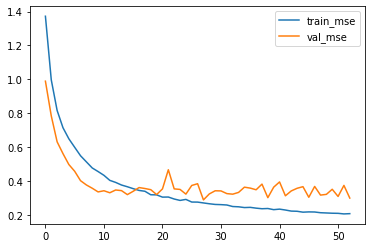

In [ ]:
from matplotlib import pyplot

# plot training history
pyplot.plot(history.history['mean_squared_error'], label='train_mse')
pyplot.plot(history.history['val_mean_squared_error'], label='val_mse')
pyplot.legend()
pyplot.show()